In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import equinox as eqx
import optax
import numpy as np
from pyscf import dft, scf, gto, cc
from pyscfad import dft as dft_ad
from pyscfad import gto as gto_ad
from functools import partial
import pylibxc
import pyscfad.dft as dftad
from jax import custom_jvp
jax.config.update("jax_enable_x64", True) #Enables 64 bit precision
from ase.io import read

from xcquinox import net
from xcquinox.loss import compute_loss_mae
from xcquinox.train import Pretrainer
from xcquinox.utils import gen_grid_s, PBE_Fx, PBE_Fc, calculate_stats, lda_x, pw92c_unpolarized

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/dft/libxc.py:773: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


# Pre-training SCAN Networks

Since we now need access to higher derivative values (like $\nabla^2 \rho$ and $\tau$), I will opt for physical values generated by a PySCF calculation to generate the necessary inputs.

Below, I create the SCAN and HEG functions from `pylibxc` to generate the enhancement factors later.

In [2]:
func_scan_x = pylibxc.LibXCFunctional("mgga_x_scan", "unpolarized")
func_scan_c = pylibxc.LibXCFunctional("mgga_c_scan", "unpolarized")

func_lda_x = pylibxc.LibXCFunctional("lda_x", "unpolarized")
func_lda_c = pylibxc.LibXCFunctional("lda_c_pw", "unpolarized")

Below, I load in the G2/97 dataset saved in the `xcquinox/scrips/script_data` folder. I will select from this set the molecules `LiH` and `LiF` to generate relevant training points.

In [3]:
g297 = read('/home/awills/Documents/Research/xcquinox/scripts/script_data/haunschild_g2/g2_97.traj', ':')

In [4]:
for idx, at in enumerate(g297):
    print(idx, at, at.info)

0 Atoms(symbols='OC', pbc=False, calculator=SinglePointCalculator(...)) {'CO': True, 'name': 'Carbon monoxide'}
1 Atoms(symbols='CS', pbc=False, calculator=SinglePointCalculator(...)) {'CS': True, 'name': 'Carbon monosulfide'}
2 Atoms(symbols='H2', pbc=False, calculator=SinglePointCalculator(...)) {'H2': True, 'name': 'Dihydrogen'}
3 Atoms(symbols='FH', pbc=False, calculator=SinglePointCalculator(...)) {'HF': True, 'name': 'Hydrogen fluoride'}
4 Atoms(symbols='P2', pbc=False, calculator=SinglePointCalculator(...)) {'P2': True, 'name': 'Diphosphorus'}
5 Atoms(symbols='S2', pbc=False, calculator=SinglePointCalculator(...)) {'S2': True, 'name': 'Disulfur'}
6 Atoms(symbols='SH', pbc=False, calculator=SinglePointCalculator(...)) {'HS': True, 'name': 'Mercapto radical'}
7 Atoms(symbols='OS', pbc=False, calculator=SinglePointCalculator(...)) {'OS': True, 'name': 'Sulfur monoxide'}
8 Atoms(symbols='C2H', pbc=False, calculator=SinglePointCalculator(...)) {'C2H': True, 'name': 'Ethynyl radical'}

In [5]:
#we'll use LiF and LiH as our molecules to generate the relevant grids and descriptors
selected_mol_inds = [25, 26]
selected_mols = [g297[i] for i in selected_mol_inds]
for idx, at in enumerate(selected_mols):
    print(idx, at, at.info)

0 Atoms(symbols='LiF', pbc=False, calculator=SinglePointCalculator(...)) {'LiF': True, 'name': 'Lithium fluoride'}
1 Atoms(symbols='LiH', pbc=False, calculator=SinglePointCalculator(...)) {'LiH': True, 'name': 'Lithium hydride'}


Below, I generate the necessary grid data that we will need. At the MGGA level, `dft.numint.eval_rho` returns an array of $\rho,\nabla_x\rho,\nabla_y\rho,\nabla_z\rho,\nabla^2\rho,\tau$.

In [6]:
for idx, at in enumerate(selected_mols):
    print(idx, at)
    syms = at.get_chemical_symbols()
    pos = at.positions
    atstr = '; '.join(['{} {} {} {}'.format(syms[i], pos[i][0], pos[i][1], pos[i][2]) for i in range(len(syms))])
    mol = gto.M(atom=atstr, basis='def2-tzvpd')
    mf = dft.RKS(mol)
    mf.xc = 'scan,scan'
    mf.grids.level = 5
    mf.kernel()
    ao = dft.numint.eval_ao(mol, mf.grids.coords, deriv=2)
    dm = mf.make_rdm1()
    rho = dft.numint.eval_rho(mol, ao, dm, with_lapl=True, xctype='MGGA')
    if idx == 0:
        total_rho = rho
    else:
        total_rho = np.hstack([total_rho, rho])

0 Atoms(symbols='LiF', pbc=False, calculator=SinglePointCalculator(...))
converged SCF energy = -107.434995479272
1 Atoms(symbols='LiH', pbc=False, calculator=SinglePointCalculator(...))
converged SCF energy = -8.06737171564215


In [7]:
total_rho.shape

(6, 138304)

Below, I take the gradient and transform it into $\sigma=|\nabla\rho|^2$ as that is what libxc expects, alongside the laplacian and tau.

In [8]:
total_rho_rho = total_rho[0, :]
total_rho_sigma = total_rho[1, :]**2 + total_rho[2, :]**2 + total_rho[3, :]**2
total_rho_lapl = total_rho[4, :]
total_rho_tau = total_rho[5, :]
total_rho_inp = np.vstack([total_rho_rho, total_rho_sigma, total_rho_lapl, total_rho_tau])
pylibxc_inp = {'rho': total_rho_rho,
               'sigma': total_rho_sigma,
               'lapl': total_rho_lapl,
               'tau': total_rho_tau
              }

In [9]:
total_rho_inp.shape

(4, 138304)

Now we use the functions instantiated above to calculate the SCAN and HEG $e_x$ and $e_c$ values, which we divide to get the resulting SCAN enhancement factor values on the grid.

In [10]:
ref_scan_x = func_scan_x.compute(pylibxc_inp)
ref_scan_c = func_scan_c.compute(pylibxc_inp)

ref_lda_x = func_lda_x.compute(pylibxc_inp)
ref_lda_c = func_lda_c.compute(pylibxc_inp)

ref_scan_Fx = (ref_scan_x['zk']/ref_lda_x['zk'])[0]
ref_scan_Fc = (ref_scan_c['zk']/ref_lda_c['zk'])[0]

Below I set up a 85/15 train/test split with the points generated above.

In [12]:
#set up training/test indices
num_pts = total_rho_rho.shape[0]
inds = np.arange(num_pts)

Ntrain = int(0.85*num_pts)
Ntest = num_pts - Ntrain
np.random.seed(12345)
train_inds = np.random.choice(inds, size=Ntrain, replace=False)
test_inds = [i for i in inds if i not in train_inds]

train_pts = total_rho_inp[:, train_inds]
test_pts = total_rho_inp[:, test_inds]
train_ref_Fx = ref_scan_Fx[train_inds]
train_ref_Fc = ref_scan_Fc[train_inds]

test_ref_Fx = ref_scan_Fx[test_inds]
test_ref_Fc = ref_scan_Fc[test_inds]

The references and inputs are generated, now we train.

In [14]:
#sigma-based networks
s_scan_fx = net.MGGA_FxNet_sigma(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)
s_scan_fc = net.MGGA_FcNet_sigma(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)
s_scan_fx_tr = net.MGGA_FxNet_sigma_transform(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)
s_scan_fc_tr = net.MGGA_FcNet_sigma_transform(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)

I will train each network over 5000 steps with a linear schedule to decrease the LR over time.

In [15]:
OPT_INIT_LR = 1e-2
OPT_END_LR = 1e-6
OPTSTEPS = 5000
OPTDECAYBEGIN = 1000
# OPTDECAYRATE = 0.95
scheduler = optax.linear_schedule(
    init_value = OPT_INIT_LR,
    transition_steps = OPTSTEPS-OPTDECAYBEGIN,
    transition_begin = OPTDECAYBEGIN,
    end_value = OPT_END_LR,
)

#create optimizers
optimizer = optax.chain(
    optax.adam(learning_rate=scheduler)
)
#train points shape mismatch -- typical shape vmap expects is (Npts, Ninputs), but eval_rho gives us the opposite shape.
pt_scan_fx = Pretrainer(model = s_scan_fx, optim = optimizer, inputs = train_pts.T, ref = train_ref_Fx, loss = compute_loss_mae, steps = OPTSTEPS)
pt_scan_fc = Pretrainer(model = s_scan_fc, optim = optimizer, inputs = train_pts.T, ref = train_ref_Fc, loss = compute_loss_mae, steps = OPTSTEPS)

pt_scan_fxt = Pretrainer(model = s_scan_fx_tr, optim = optimizer, inputs = train_pts.T, ref = train_ref_Fx, loss = compute_loss_mae, steps = OPTSTEPS)
pt_scan_fct = Pretrainer(model = s_scan_fc_tr, optim = optimizer, inputs = train_pts.T, ref = train_ref_Fc, loss = compute_loss_mae, steps = OPTSTEPS)

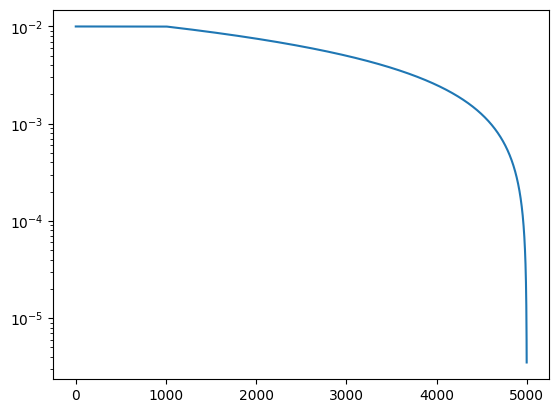

In [16]:
plt.plot(scheduler(np.arange(0, OPTSTEPS)))
plt.yscale('log')

In [17]:
nmx, nlx = pt_scan_fx()
nmc, nlc = pt_scan_fc()

nmxt, nlxt = pt_scan_fxt()
nmct, nlct = pt_scan_fct()

Epoch 0: Loss = 0.2507050458817731
Epoch 100: Loss = 0.027371617959587518
Epoch 200: Loss = 0.05063620939401005
Epoch 300: Loss = 0.02580552572324775
Epoch 400: Loss = 0.021917646708344604
Epoch 500: Loss = 0.048850691914202146
Epoch 600: Loss = 0.018582845358245705
Epoch 700: Loss = 0.017764793034877567
Epoch 800: Loss = 0.02866226796735522
Epoch 900: Loss = 0.025371127470973132
Epoch 1000: Loss = 0.01372745265258103
Epoch 1100: Loss = 0.028948098674822276
Epoch 1200: Loss = 0.06545966967948655
Epoch 1300: Loss = 0.03273842749990566
Epoch 1400: Loss = 0.029375995137705384
Epoch 1500: Loss = 0.030427414073387178
Epoch 1600: Loss = 0.02890659733837883
Epoch 1700: Loss = 0.026889522778759927
Epoch 1800: Loss = 0.021796070578522665
Epoch 1900: Loss = 0.0253432040389776
Epoch 2000: Loss = 0.027841996041939737
Epoch 2100: Loss = 0.023609285668686558
Epoch 2200: Loss = 0.024351038882703787
Epoch 2300: Loss = 0.02167800852809972
Epoch 2400: Loss = 0.021919445383163004
Epoch 2500: Loss = 0.020

In [18]:
test_pred_fx = jax.vmap(nmx)(test_pts.T)
test_pred_fc = jax.vmap(nmc)(test_pts.T)

fx_mae = np.mean(abs(test_pred_fx - test_ref_Fx))
fc_mae = np.mean(abs(test_pred_fc - test_ref_Fc))
print(fx_mae, fc_mae)

test_pred_fxt = jax.vmap(nmxt)(test_pts.T)
test_pred_fct = jax.vmap(nmct)(test_pts.T)

fxt_mae = np.mean(abs(test_pred_fxt - test_ref_Fx))
fct_mae = np.mean(abs(test_pred_fct - test_ref_Fc))
print(fxt_mae, fct_mae)


0.008109666587063333 0.013427646751520122
0.0010533014125519062 0.0033964486517764846


Text(0.5, 0.98, 'Enhancement Factor Errors\nFunction Inputs: [$\\rho,\\sigma,\\nabla\\rho,\\tau$]\nNetwork Inputs: [$\\rho,s,\\alpha$]')

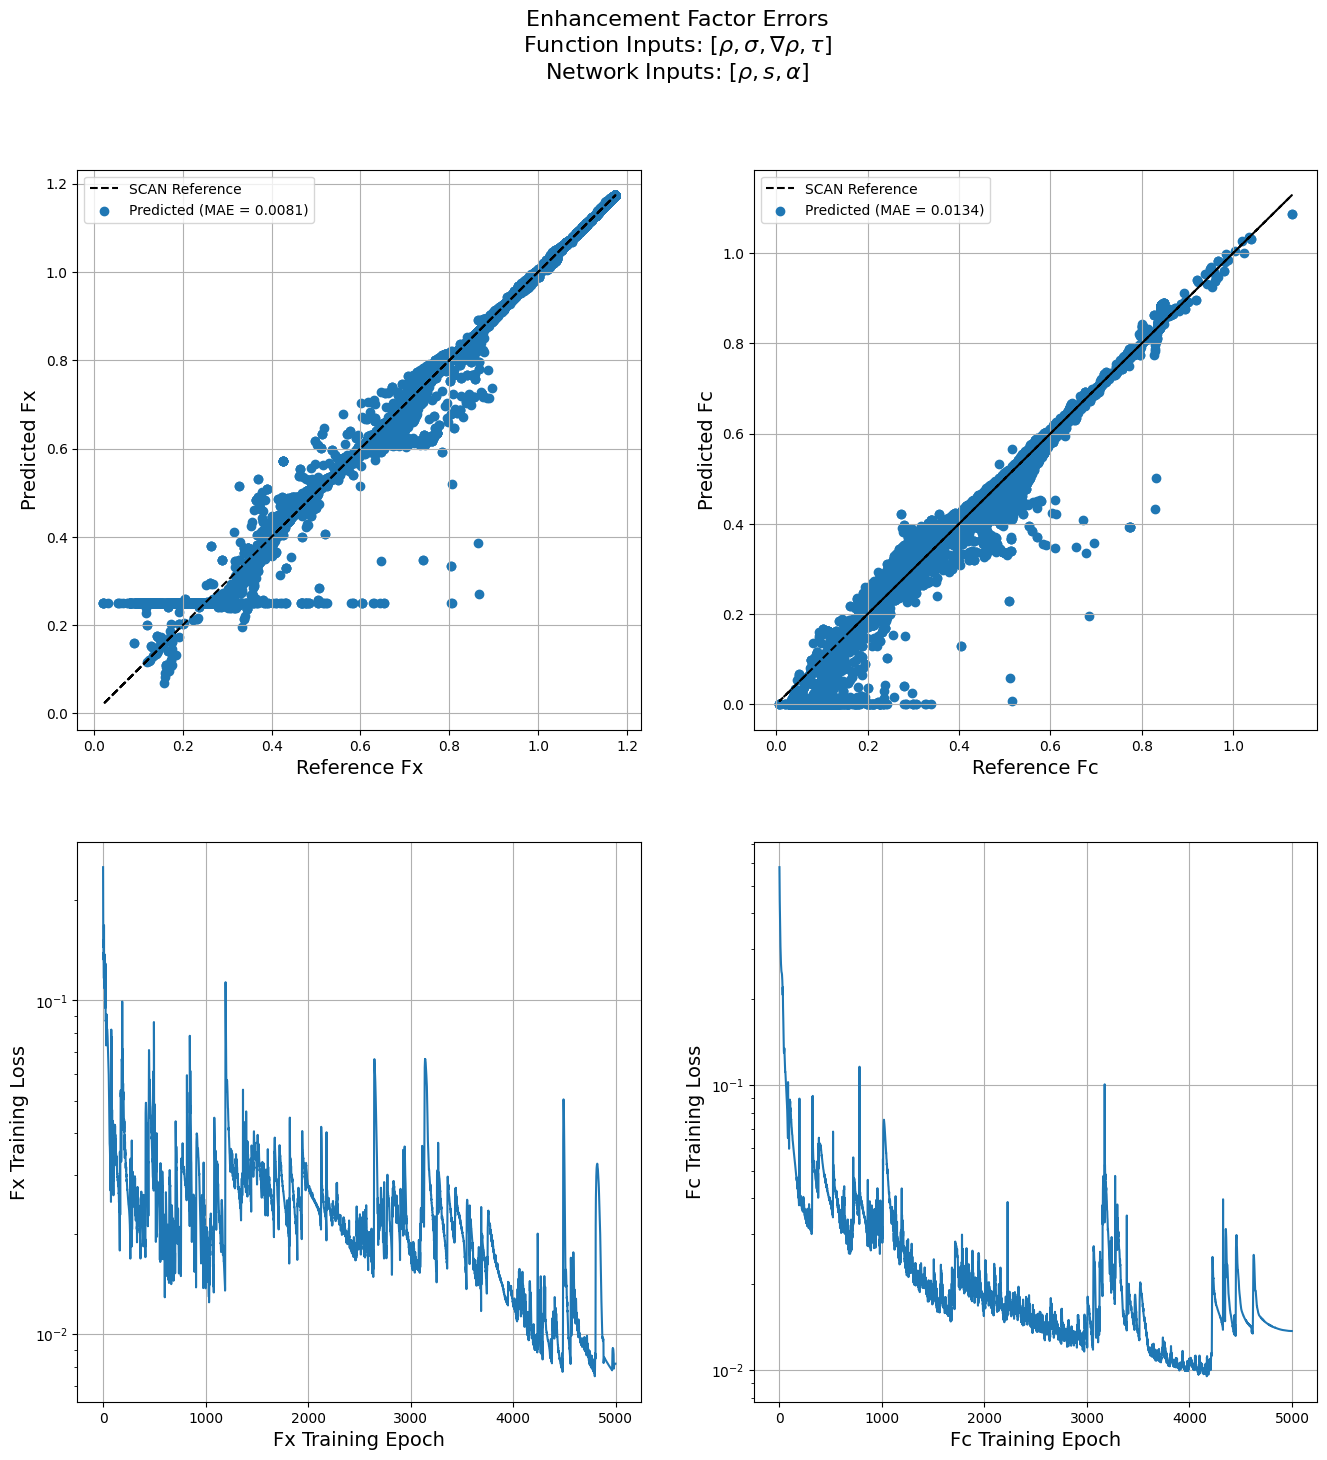

In [19]:
f = plt.figure(figsize=(16,16))
axx = f.add_subplot(221)
axc = f.add_subplot(222)
axxl = f.add_subplot(223)
axcl = f.add_subplot(224)

axx.plot(test_ref_Fx, test_ref_Fx, 'k--', label='SCAN Reference')
axc.plot(test_ref_Fc, test_ref_Fc, 'k--', label='SCAN Reference')

axx.scatter(test_ref_Fx, test_pred_fx, label='Predicted (MAE = {:3.4f})'.format(fx_mae))
axc.scatter(test_ref_Fc, test_pred_fc, label='Predicted (MAE = {:3.4f})'.format(fc_mae))

axxl.plot(np.arange(0, OPTSTEPS), nlx)
axcl.plot(np.arange(0, OPTSTEPS), nlc)

axx.legend()
axc.legend()

axx.set_xlabel('Reference Fx', fontsize=14)
axx.set_ylabel('Predicted Fx', fontsize=14)
axxl.set_xlabel('Fx Training Epoch', fontsize=14)
axxl.set_ylabel('Fx Training Loss', fontsize=14)

axc.set_xlabel('Reference Fc', fontsize=14)
axc.set_ylabel('Predicted Fc', fontsize=14)
axcl.set_xlabel('Fc Training Epoch', fontsize=14)
axcl.set_ylabel('Fc Training Loss', fontsize=14)

axxl.set_yscale('log')
axcl.set_yscale('log')

axx.grid()
axc.grid()
axxl.grid()
axcl.grid()

plt.suptitle('Enhancement Factor Errors\nFunction Inputs: [$\\rho,\\sigma,\\nabla\\rho,\\tau$]\nNetwork Inputs: [$\\rho,s,\\alpha$]',fontsize=16)

Text(0.5, 0.98, 'Enhancement Factor Errors\nFunction Inputs: [$\\rho,\\sigma,\\nabla\\rho,\\tau$]\nNetwork Inputs: [$\\tilde{x}_0,\\tilde{x}_2,\\tilde{x}_3$]')

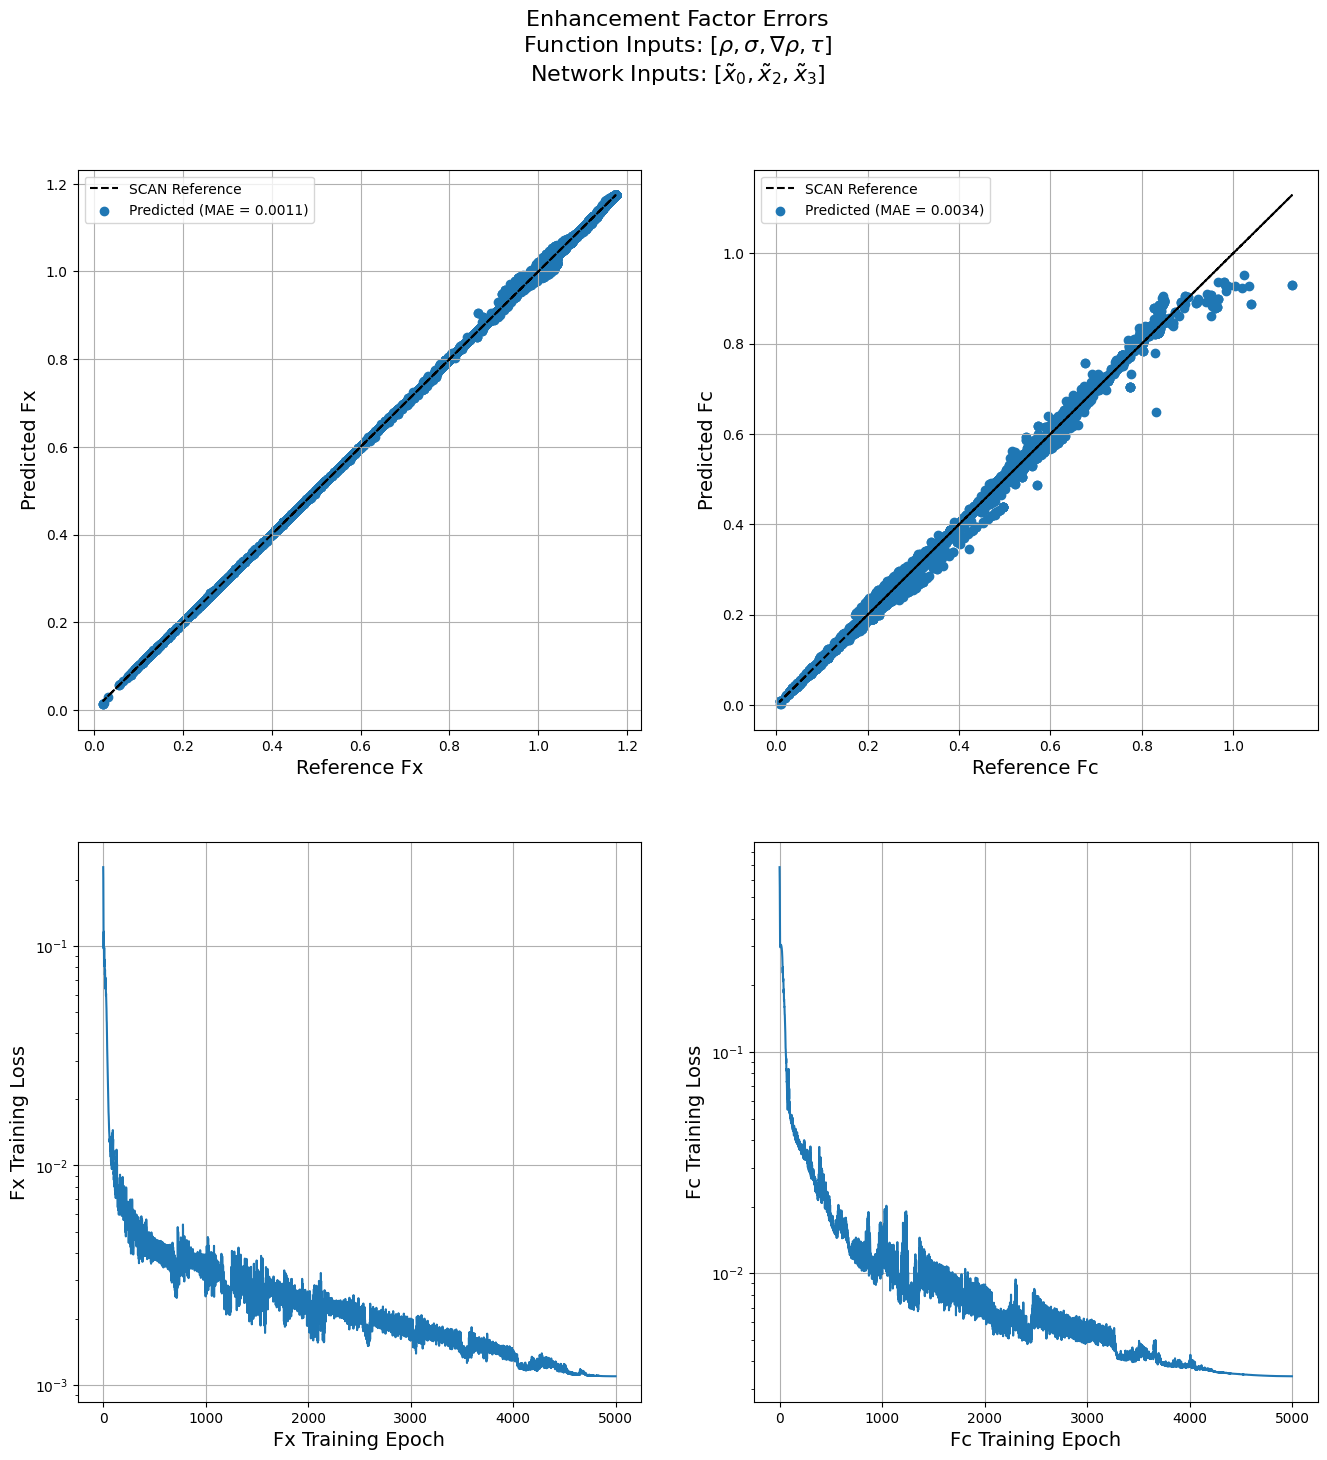

In [20]:
f = plt.figure(figsize=(16,16))
axx = f.add_subplot(221)
axc = f.add_subplot(222)
axxl = f.add_subplot(223)
axcl = f.add_subplot(224)

axx.plot(test_ref_Fx, test_ref_Fx, 'k--', label='SCAN Reference')
axc.plot(test_ref_Fc, test_ref_Fc, 'k--', label='SCAN Reference')

axx.scatter(test_ref_Fx, test_pred_fxt, label='Predicted (MAE = {:3.4f})'.format(fxt_mae))
axc.scatter(test_ref_Fc, test_pred_fct, label='Predicted (MAE = {:3.4f})'.format(fct_mae))

axxl.plot(np.arange(0, OPTSTEPS), nlxt)
axcl.plot(np.arange(0, OPTSTEPS), nlct)

axx.legend()
axc.legend()

axx.set_xlabel('Reference Fx', fontsize=14)
axx.set_ylabel('Predicted Fx', fontsize=14)
axxl.set_xlabel('Fx Training Epoch', fontsize=14)
axxl.set_ylabel('Fx Training Loss', fontsize=14)

axc.set_xlabel('Reference Fc', fontsize=14)
axc.set_ylabel('Predicted Fc', fontsize=14)
axcl.set_xlabel('Fc Training Epoch', fontsize=14)
axcl.set_ylabel('Fc Training Loss', fontsize=14)

axxl.set_yscale('log')
axcl.set_yscale('log')

axx.grid()
axc.grid()
axxl.grid()
axcl.grid()

plt.suptitle('Enhancement Factor Errors\nFunction Inputs: [$\\rho,\\sigma,\\nabla\\rho,\\tau$]\nNetwork Inputs: [$\\tilde{x}_0,\\tilde{x}_2,\\tilde{x}_3$]',fontsize=16)